# TCP拥塞控制和Bufferbloat


 在本作业中，你将创建自己的模拟网络，以动态地研究TCP，以及网络操作员看似微不足道的配置决策是如何对网络性能产生重大影响的。

TCP是一种在不可靠的分组交换网络上获得可靠传输的协议。TCP的一个重要组成部分是拥塞控制算法，比如限制终端主机发送速率，以防止网络基础设施不堪重负的流量。

然而，即使终端主机使用TCP，网络也会遇到拥塞相关的性能问题。当路由器和交换机上的包缓冲区过大时，就会出现Bufferbloat的问题。

在本作业中，您将使用Mininet(一个很有用的网络实验工具)来模拟一个小型网络，并收集与TCP拥塞控制和Bufferbloat相关的各种性能统计数据。这将允许你推断TCP和路由器配置对网络性能的影响。

**请在下方填入你的姓名和学号:**


**姓名:**
黄潇颖

**学号:**
2020201622

## 背景

#### TCP拥塞窗口
TCP拥塞窗口大小参数，通常简写为“cwnd”，由发送方维护，并决定在任何时候有多少流量可以处于未完成状态(已发送但未被确认)。在TCP运行过程中，控制cwnd的值有很多算法，它们的目标都是在防止拥塞的同时最大化连接的吞吐量。

#### Bufferbloat
Bufferbloat是这样一种网络现象：网络中的交换设备使用了过大的缓冲区，进而导致高延迟和包延迟变化(抖动)。这种现象甚至可以发生在一个典型的家庭网络，如以下:
<img width=600 src="figures/home-network.png">
在图中，家庭网络中的终端主机连接到家庭路由器。然后，家庭路由器通过电缆或DSL连接到由互联网服务提供商(ISP)运行的路由器。通过在Mininet中模拟和试验一个类似的网络，你将观察到bufferbloat是如何导致网络性能低下的。

#### Mininet
Mininet是一个网络模拟器，你可以使用它创建一个自定义的网络虚拟主机，交换机，控制器和链路，所有在一台计算机上。仿真网络中的虚拟设备可以运行真实的程序;任何可以在linux上运行的东西也可以在Mininet设备上运行。这使得Mininet成为快速、简单地模拟网络协议和测量的有价值的工具。这个[Mininet简介](https://github.com/mininet/mininet/wiki/Introduction-to-Mininet)是一个有用的指南，可以帮助你开始使用Mininet的Python API。如果你感兴趣，[Mininet网站](http://www.mininet.org)有更多的资源。

## Part A: 网络仿真和数据度量
首先，使用Mininet的Python API创建以下网络，这是一个典型的家庭网络:
<img width=450 src="figures/mininet-topo.png">
图中h1是一个网络服务器，有一个高带宽连接(1Gb/s)到你的家用路由器。家用路由器的下行连接速度较慢(1.5Mb/s)。往返传播延迟，即h1和h2之间的最小RTT(round-trip time)为20ms。路由器缓冲区(队列)大小将是这个模拟中的自变量。

在Mininet中创建自定义网络拓扑，我们扩展了Mininet.topo.Topo类。你需要添加交换机（路由器）s0，主机h1、h2和具有适当特征的链接，以创建上面图像中指定的设置。Mininet指南的[使用Mininet](https://github.com/mininet/mininet/wiki/Introduction-to-Mininet#creating)部分的前几个小节描述了如何向网络拓扑中添加元素和设置参数。

In [1]:
from mininet.topo import Topo

class BBTopo(Topo):
    "Simple topology for bufferbloat experiment."

    def __init__(self, queue_size):
        super(BBTopo, self).__init__()
        
        # TODO: Create switch s0 (the router)
        s0 = self.addSwitch('s0')
        
        # TODO: Create two hosts with names 'h1' and 'h2'
        h1=self.addHost('h1')
        h2=self.addHost('h2')
        
        # TODO: Add links with appropriate bandwidth, delay, and queue size parameters. 
        #       Set the router queue size using the queue_size argument
        #       Set bandwidths/latencies using the bandwidths and minimum RTT given in the network diagram above
        self.addLink(s0,h1,bw=1000,delay='20ms',max_queue_size=queue_size)
        self.addLink(s0,h2,bw=1.5,delay='20ms',max_queue_size=queue_size)

        return

接下来，我们需要两个辅助函数来生成两个主机之间的通信数据。下面的函数启动一个长生命周期的TCP流，使用**Iperf**将数据从h1发送到h2。[Iperf](https://iperf.fr/)是一个能够主动测量IP网络上最大带宽的工具。你可以把这种iperf通信想象成单向的视频通话。它不断地尝试从web服务器h1向家庭计算机h2发送大量的通信数据。

函数接收一个名为' net '的参数，它是我们在上面创建的带有BBTopo拓扑的mininet实例。我们已经编写了iperf server(h2)的部分。需要注意的是，在iperf中，iperf server是接收数据的一方，在我们的场景里，它应该是h2。你还需要补全该函数，以便在iperf client(h1)上启动iperf。iperf会话的运行时长应该由'experiment_time'参数给出的秒数决定。

你需要使用'popen'函数在mininet主机上运行shell命令。'popen'的第一个参数是一个字符串命令，就像你在shell中运行的那样。第二个参数应该是'shell=True'。你需要在[文档](https://iperf.fr/iperf-doc.php#3doc)中查找适当的命令行选项，以便在给定的时间内作为客户端运行iperf。您还需要在iperf命令中包含h2的IP地址。这个IP地址可以通过'h2.IP()'方法获得。

In [2]:
def start_iperf(net, experiment_time):
    # TODO:
    # Start a TCP server on host 'h2' using perf. 
    # The -s parameter specifies server mode
    # The -w 16m parameter ensures that the TCP flow is not receiver window limited (not necessary for client)
    print "Starting iperf server"
    
    h2=net.get('h2')
    
    h2_server_start_cmd='iperf -D -s -w 16M '
    
    h2.popen(h2_server_start_cmd,shell=True)
    
    # TODO: Start an TCP client on host 'h1' using iperf. 
    #       Ensure that the client runs for experiment_time seconds
    print "Starting iperf client"
    
    h1=net.get('h1')
    
    ip_h2=h2.IP()
    
    h1_server_start_cmd='iperf -D -t '+str(experiment_time)+' -c '+ip_h2
    h1.popen(h1_server_start_cmd,shell=True)


接下来，你需要完成以下函数，从h1到h2启动一个连续的ping来测量rtt。每0.1秒发送一次ping。结果应该从stdout重定向到outfile参数。

和之前一样，'net'是一个带有BBTopo拓扑的mininet实例。你需要使用'popen'。'popen'的命令参数可以使用'>'重定向stdout，就像普通的shell命令一样。有关可用命令行参数的详细信息，请参阅'ping'的man手册。确保'popen'的第二个参数是'shell=True'。

In [3]:

def start_ping(net, outfile="pings.txt"):
    # TODO: Start a ping train from h1 to h2 with 0.1 seconds between pings, redirecting stdout to outfile
    print "Starting ping train"
    h1=net.get('h1')
    h2=net.get('h2')
    
    #ping -c 10 -i 0.1 h2
    ping_cmd='ping -i 0.1 '+h2.IP()+' > '+outfile
    
    h1.popen(ping_cmd,shell=True)
   
       
    


接下来，我们提供了一些辅助函数来监测TCP的拥塞窗口大小。这将让我们能够动态地分析在mininet网络中的TCP连接。以下函数已经完成。

In [4]:
from subprocess import Popen
import os

def start_tcpprobe(outfile="cwnd.txt"):
    Popen("sudo cat /proc/net/tcpprobe > " + outfile, shell=True)

def stop_tcpprobe():
    Popen("killall -9 cat", shell=True).wait()

接下来，我们创建一个辅助函数来监测给定接口上的等待队列的长度。这将让我们分析路由器缓冲区队列中的数据包的数量以及它是如何影响网络性能的。此函数已经完成。

In [5]:
from multiprocessing import Process
from monitor import monitor_qlen

def start_qmon(iface, interval_sec=0.1, outfile="q.txt"):
    monitor = Process(target=monitor_qlen,
                      args=(iface, interval_sec, outfile))
    monitor.start()
    return monitor

我们还需要一个辅助函数，以在h1上启动一个web服务器。此函数已经完成。

In [6]:
from time import sleep

def start_webserver(net):
    h1 = net.get('h1')
    proc = h1.popen("python http/webserver.py", shell=True)
    sleep(1)
    return [proc]

最后，我们需要一个在h2上运行的辅助函数，每3秒从h1获取一个网页(可以使用curl指令)，这个过程将持续experiment_time秒。每次获取网页时，输出网页的下载时间和剩余实验时间。最计算experiment_time内下载时间的平均值和标准差并输出。

In [7]:
from time import time
from numpy import mean, std
from time import sleep

def fetch_webserver(net, experiment_time):
#TODO: 
    h1=net.get('h1')
    h2=net.get('h2')
    

    start_time = time() #启动时间
    end_time = start_time + experiment_time #实验结束时间
    download_times = []
    
    get_web_cmd='curl -o /dev/null -s -w https://'+ h1.IP()+'/index.html'
    print(get_web_cmd)

    while time() < end_time:
        #获取网页
        download_start = time()
        h2.popen(get_web_cmd,shell=True) 
        download_end = time()
        
        download_times.append(download_end - download_start)
        remaining_time = end_time - time()
        print("Download time: {:.2f} seconds. Remaining experiment time: {:.2f} seconds.".format(download_end - download_start, remaining_time))
        sleep(3)
        
    avg_download_time = sum(download_times) / len(download_times)
    std_dev_download_time = (sum([(x - avg_download_time) ** 2 for x in download_times]) / len(download_times)) ** 0.5
    print("Average download time: {:.2f} seconds. Standard deviation of download times: {:.2f} seconds.".format(avg_download_time, std_dev_download_time))
    

现在，我们需要把所有这些部分组合在一起。我们需要创建网络，启动所有的流量，并进行测量。

下面的`bufferbloat()`函数需要做：
* 创建一个`BBTopo`对象
* 启动TCP
* 启动cwnd窗口大小监测
* 启动队列监测
* 使用iperf启动一个长生命周期的TCP流
* 启动ping消息队列
* 启动Web服务器
* 周期性地从h1下载index.html网页，并测量所需时间

需要注意的是，TCP流、ping序列和web服务器下载应该同时发生。如果你完成了之前的任务步骤，你需要完成在下面'bufferbloat()'函数中标记为'TODO'的部分。每个TODO部分都需要添加一行来调用上面定义的函数。

In [8]:
from mininet.node import CPULimitedHost, OVSController
from mininet.link import TCLink
from mininet.net import Mininet
from mininet.log import lg, info
from mininet.util import dumpNodeConnections

from time import time
import os
from subprocess import call

def bufferbloat(queue_size, experiment_time, experiment_name):
    # Don't forget to use the arguments!
    
    # Set the cwnd control algorithm to "reno" (half cwnd on 3 duplicate acks)
    #    Modern Linux uses CUBIC-TCP by default that doesn't have the usual sawtooth
    #    behaviour.  For those who are curious, replace reno with cubic
    #    see what happens...
    os.system("sysctl -w net.ipv4.tcp_congestion_control=reno")
    
    # TODO: create the topology and network
    
    topo = BBTopo(queue_size)
    net = Mininet(topo=topo, host=CPULimitedHost, link=TCLink, 
                  controller= OVSController)
    
    # TODO: start the net
    net.start()

    # TODO: Print the network topology 
    dumpNodeConnections( net.hosts )

    # TODO: Performs a basic all pairs ping test to ensure the network set up properly
    net.pingAll()
    
    # Start monitoring TCP cwnd size
    outfile = "{}_cwnd.txt".format(experiment_name)
    start_tcpprobe(outfile)

    # TODO: Start monitoring the queue sizes with the start_qmon() function.
    #       Fill in the iface argument with "s0-eth2" if the link from s0 to h2
    #       is added second in BBTopo or "s0-eth1" if the link from s0 to h2
    #       is added first in BBTopo. This is because we want to measure the 
    #       number of packets in the outgoing queue from s0 to h2. 
    outfile = "{}_qsize.txt".format(experiment_name)
    qmon = start_qmon(iface="s0-eth2", outfile=outfile)
    
    # TODO: Start the long lived TCP connections with the start_iperf() function
    start_iperf(net,experiment_time)
    
    # TODO: Start pings with the start_ping() function
    outfile = "{}_pings.txt".format(experiment_name)
    start_ping(net,outfile)
    
    # TODO: Start the webserver with the start_webserver() function
    start_webserver(net)
    
    # TODO: Measure and print website download times with the fetch_webserver() function
    fetch_webserver(net,experiment_time)
    
    # Stop probing 
    stop_tcpprobe()
    qmon.terminate()
    
    #TODO: stop the net
    net.stop()
    
    # Ensure that all processes you create within Mininet are killed.
    Popen("pgrep -f webserver.py | xargs kill -9", shell=True).wait()
    call(["mn", "-c"])

当你完成上述所有步骤后，使用bufferbloat()函数运行两次实验，一次队列大小为20个包，一次队列大小为100个包。确保运行实验的时间足够长，以便在结果中看到TCP的动态变化，比如cwnd的锯齿状行为(300秒应该就够了)。选择反映队列大小的experiment_name参数

In [9]:
from subprocess import call
call(["mn", "-c"])

# TODO: call the bufferbloat function twice, once with queue size of 20 packets and once with a queue size of 100.
bufferbloat(20, 300, 'temp/20pkg-test')
bufferbloat(100, 300, 'temp/100pkg-test')

h1 h1-eth0:s0-eth1
h2 h2-eth0:s0-eth2
*** Ping: testing ping reachability
h1 -> h2 
h2 -> h1 
*** Results: 0% dropped (2/2 received)


Starting iperf server
Starting iperf client
Starting ping train
curl -o /dev/null -s -w https://10.0.0.1/index.html
Download time: 0.01 seconds. Remaining experiment time: 299.99 seconds.
Download time: 0.00 seconds. Remaining experiment time: 296.97 seconds.
Download time: 0.01 seconds. Remaining experiment time: 293.96 seconds.
Download time: 0.01 seconds. Remaining experiment time: 290.95 seconds.
Download time: 0.01 seconds. Remaining experiment time: 287.93 seconds.
Download time: 0.02 seconds. Remaining experiment time: 284.90 seconds.
Download time: 0.02 seconds. Remaining experiment time: 281.86 seconds.
Download time: 0.01 seconds. Remaining experiment time: 278.84 seconds.
Download time: 0.01 seconds. Remaining experiment time: 275.82 seconds.
Download time: 0.00 seconds. Remaining experiment time: 272.80 seconds.
Download time: 0.01 seconds. Remaining experiment time: 269.78 seconds.
Download time: 0.01 seconds. Remaining experiment time: 266.76 seconds.
Download time: 0.01 

h1 h1-eth0:s0-eth1
h2 h2-eth0:s0-eth2
*** Ping: testing ping reachability
h1 -> h2 
h2 -> h1 
*** Results: 0% dropped (2/2 received)


Starting iperf server
Starting iperf client
Starting ping train
curl -o /dev/null -s -w https://10.0.0.1/index.html
Download time: 0.01 seconds. Remaining experiment time: 299.99 seconds.
Download time: 0.01 seconds. Remaining experiment time: 296.98 seconds.
Download time: 0.01 seconds. Remaining experiment time: 293.95 seconds.
Download time: 0.01 seconds. Remaining experiment time: 290.93 seconds.
Download time: 0.01 seconds. Remaining experiment time: 287.91 seconds.
Download time: 0.00 seconds. Remaining experiment time: 284.89 seconds.
Download time: 0.01 seconds. Remaining experiment time: 281.86 seconds.
Download time: 0.00 seconds. Remaining experiment time: 278.84 seconds.
Download time: 0.01 seconds. Remaining experiment time: 275.82 seconds.
Download time: 0.00 seconds. Remaining experiment time: 272.81 seconds.
Download time: 0.01 seconds. Remaining experiment time: 269.78 seconds.
Download time: 0.00 seconds. Remaining experiment time: 266.77 seconds.
Download time: 0.01 

## Part B: 结果可视化

在这一部分中，你将通过绘制拥塞窗口、队列长度和ping RTT随时间的变化来分析实验结果。我们为每个度量提供了绘图函数，这些函数在下面的'plot_measurements()'函数中调用，这个函数已经完成了。


In [10]:
%matplotlib inline
from plot_cwnd import plot_congestion_window
from plot_qsize import plot_queue_length
from plot_ping import plot_ping_rtt

def plot_measurements(experiment_name_list, cwnd_histogram=False):
    
    # plot the congestion window over time
    for name in experiment_name_list:
        cwnd_file = "{}_cwnd.txt".format(name)
        plot_congestion_window(cwnd_file, histogram=cwnd_histogram)
    
    # plot the queue size over time
    for name in experiment_name_list:
        qsize_file = "{}_qsize.txt".format(name)
        plot_queue_length(qsize_file)
    
    # plot the ping RTT over time
    for name in experiment_name_list:
        ping_file = "{}_pings.txt".format(name)
        plot_ping_rtt(ping_file)

现在你需要调用'plot_measurements'函数，其中'experiment_name_list'参数是你在上面运行'bufferbloat()'时使用的'experiment_name'参数的列表。这个函数将生成6个带有实验结果的图。

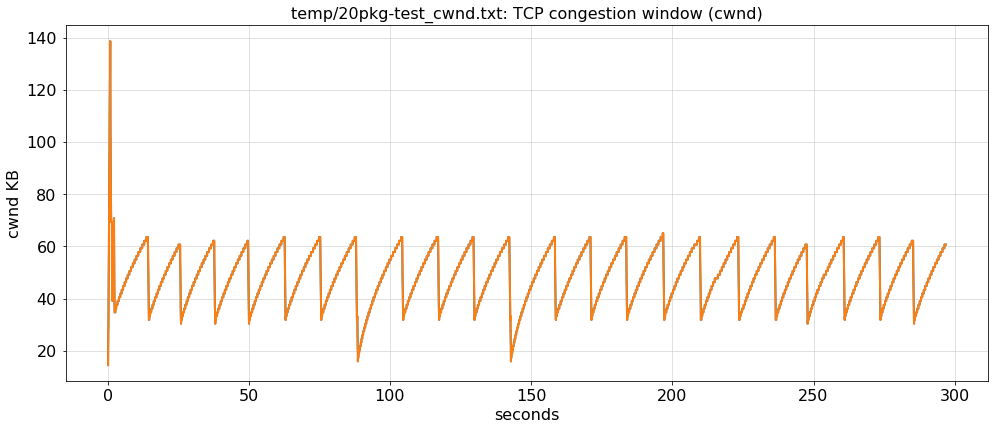

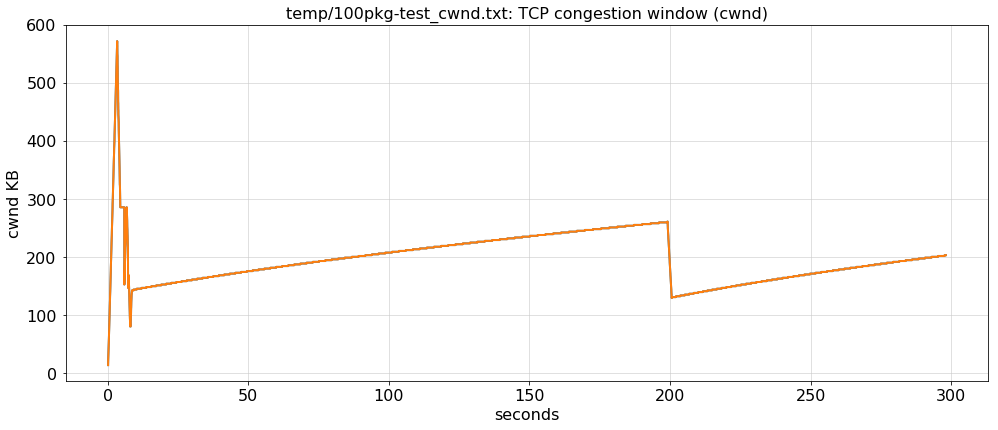

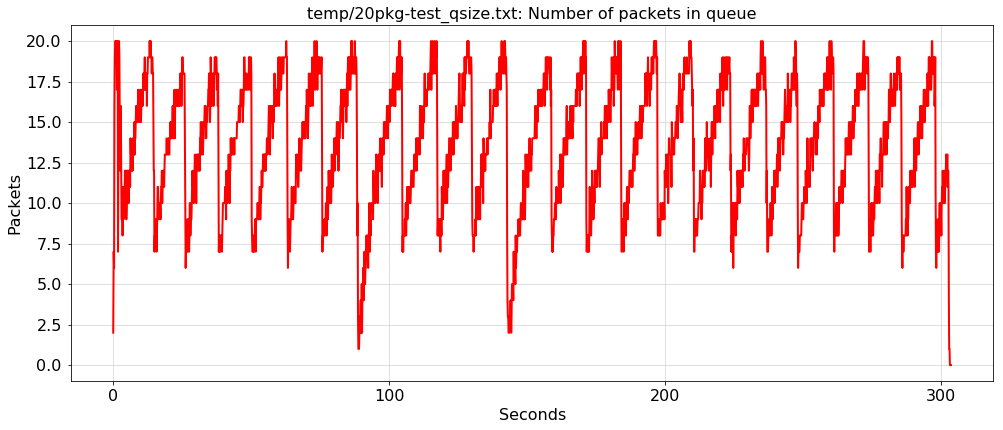

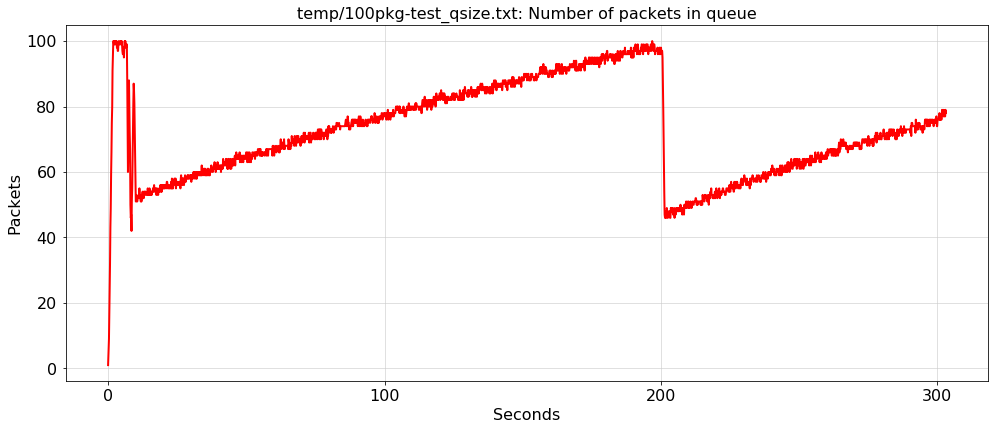

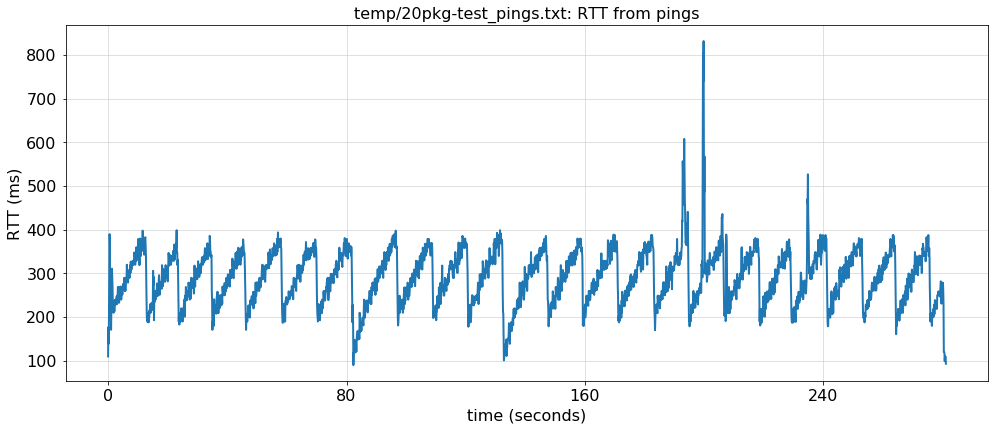

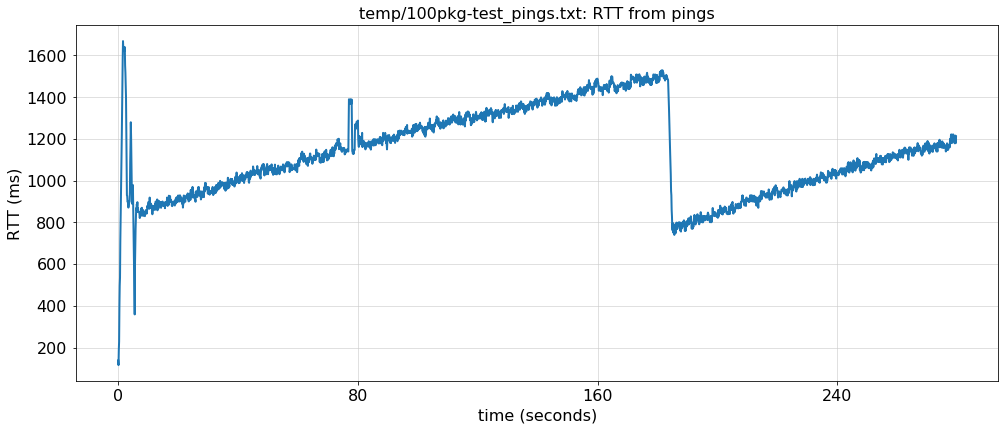

In [11]:
#TODO: Call plot_measurements() to plot your results

plot_measurements(['temp/20pkg-test','temp/100pkg-test'])

## Part C: 分析

在这一部分中，你将根据你之前的实验结果回答一些关于TCP和Bufferbloat的问题。这些问题有意设置为开放式的，许多问题有多个正确答案。答案没有长度要求，但要尽量做到详尽和简洁。1-2句话可能太短了，超过2-3段可能就太长了。

首先花点时间回忆一下刚才执行的模拟。我们模拟了一个家庭网络，家庭计算机通过路由器连接到远程服务器。从路由器到服务器的链路带宽比从家用电脑到路由器的链路带宽要低得多。在实验中，自变量是路由器发送到服务器的缓冲区的最大长度。

网络中存在三种流量数据：
1. 一个长生命周期的TCP会话(使用iperf创建)，从家用计算机向服务器发送大量的流量。
2. 家用电脑和服务器之间周期性发送的ping和ping回复。
3. 家用计算机定期尝试从Web服务器的下载(HTTP通过TCP)。

正如你通过实验发现的那样(但愿)，通过ping RTT和HTTP下载速率指标，增加路由器上的缓存的大小会显著降低性能。

### 问题

#### Q1.
除了家庭网络之外，还有哪些计算机网络具有和我们模拟的网络相似的性质?

#### A1.
我们所模拟的家庭网络是家庭计算机通过路由器连接到远程服务器。我认为校园网、企业网与其有类似的性质，即各部门/楼宇的计算机通过交换机连接路由器并与远程服务器进行连接。

#### Q2.
尝试写一个方程来描述RTT和当前队列长度之间的关系。

方程应该能够推广到任何队列长度。考虑某个时间点的系统快照，应该能够通过你的方程用队列长度$q$和链路延迟$t$来计算RTT

一个例子(不正确的):

$$RTT = kq^2$$
其中$k$是一个常数，$q$是当前队列的长度。你的方程不限制于只使用$k$和$q$，只要给出合适的理由。

#### A2.
公式
$$
RTT= kq+t
$$
其中，k与路由器的传输速率(节点处理、排队)有关，t是传播时延。

#### Q3.  
用准确的技术性的语言描述为什么增加缓冲区大小会降低TCP的性能(rtt和网页下载时间)，导致Bufferbloat。请明确地引用您生成的图以及TCP拥塞控制和缓冲区大小之间的关系。

这是该实验中比较重要的问题，将在评分中占比更多。

#### A3.
已知发送方h1的发送速率要远大于接收方h2的接收速率，增加了缓冲区的大小会使得发送方h1误以为h2有足够的处理能力，于是不断增大自己的拥塞窗口，大量的包被发往链路并进入h2的缓冲区，使得h2的处理队伍十分长，即packet in queue中缓冲区为20的队伍长度在8-20左右而缓冲区为100的队伍长度在50-100，排队延迟增大导致了RTT增加，自然网页下载时间也跟随着增加。



#### Q4. 
使用非技术性的类比来描述缓冲区膨胀效应的原因，而不是用计算机网络的专业知识。能够让外行能够理解技术内容是非常重要的，并且进行类比通常有助于您自己对问题的理解。

#### A4.
有h1,h2两个物流仓，h2每隔一段固定的时间就会让h1给它发货，每一个快递上都有存储编号，h2拿到了需要按顺序摆放并确认收货。h1和h2都有专门的人来发货和收货，h1有一个在"拥塞窗口"工作的人，他会根据收到的确认收货情况来调整可以发往路上的包裹数量。当h2的临时区被货物堆满时，没放在临时区看管的包裹就会被小偷偷走。h1等了一段时间后没收到确认收货信息，会将没有确认收货的包裹重新打包发送，并把“拥塞窗口”关小。

因为h1的发货速度实在太快了，h2处理不来，缓冲区动不动就满，丢包裹的频率太大，用户经常投诉h2，于是h2把缓冲区增大到了可以临时看管100个到达的包裹。
此时h1发现h2不怎么丢件了，于是不断把“拥塞窗口”拉开，让更多的包裹上路。可是缓冲区变大了，h2的处理速度并没有变快，于是包裹到达了h2的临时区域就要排长长的队等待被处理，h1收到确认收货的时间也更长了。

#### Q5. 
缓冲区膨胀效应是我们模拟的网络特有的，还是一种普遍现象?

是否有增加路由器缓冲区大小可以提高性能的时候?如果是，请举个例子。如果没有，解释原因。



#### A5.
1）缓冲区膨胀效应是一种普遍现象，在操作系统或分布式系统中、制造业中都会出现缓冲区膨胀效应。

2）在高流量网络环境中，路由器处理能力优秀的情况下，如果路由器的缓冲区较小，可能会丢包率上升会使链路中重传的数据包变多，导致链路拥挤。通过增大路由器的缓冲区大小，可以容纳更多的数据包，从而减少丢包的可能性。这可以提高网络性能，减少延迟。


#### Q6.
确定并描述在不减少缓冲区大小的情况下缓解缓冲区膨胀问题的方法。

#### A6.
1.流量控制：实施有效的流量控制机制可以限制进入缓冲区的数据流量，防止过多的数据包堆积。可以通过使用流量调节算法、速率限制、拥塞控制等技术来实现。
2.智能调度算法：采用智能的调度算法可以更好地管理缓冲区中的数据包。例如，使用公平的队列调度算法（Fair Queuing）或权重调度算法（Weighted Fair Queuing）。
3.缓冲区监控和报警：实时监测缓冲区的状态，并设置合适的报警机制可以及早发现缓冲区膨胀问题。当缓冲区的利用率接近阈值或达到预设的警戒线时，系统可以触发报警并采取相应的措施，如增加缓冲区大小、调整流量控制策略等。
4.数据包丢弃策略：可以采用先进先出（FIFO）或最早到达最先传输策略、主动队列管理算法、随机早期检测。

## 注意！

**在退出该notebook之前确保你的更改已经保存！(右上角的Save and Checkpoint图标按钮， 或者'Ctrl-S')**
